## Experiments September

In [1]:
%matplotlib inline
import numpy
import os
import pandas
import pickle
import matplotlib.pyplot as plt

from sklearn import metrics

In [18]:
import seaborn
seaborn.set_style('white')
seaborn.set_context("paper", font_scale=1.6)

In [3]:
def get_auc_roc_curve(true, predicted):
    results = []
    ignored_sequences = 0
    for true_sequence, predicted_sequence in zip(true, predicted):
        try:
            results.append([metrics.roc_auc_score(true_sequence, predicted_sequence),
                            true_sequence.shape[0]])
        except ValueError:
            ignored_sequences += 1
    print('{} sequences with only one class, ignoring.'.format(ignored_sequences))
    return pandas.DataFrame(results, columns=['AUC', 'Sequence lenght'])

def get_mean_auc_roc_curve(true, predicted):
    all_true = numpy.concatenate(true)
    all_predicted = numpy.concatenate(predicted)
    return metrics.roc_auc_score(all_true, all_predicted)

In [4]:
def get_rmse(true, predicted):
    results = []
    for true_sequence, predicted_sequence in zip(true, predicted):
        results.append([metrics.mean_squared_error(true_sequence, predicted_sequence)**0.5,
                        true_sequence.shape[0]])
    return pandas.DataFrame(results, columns=['RMSE', 'Sequence lenght'])

def get_mean_rmse(true, predicted):
    all_true = numpy.concatenate(true)
    all_predicted = numpy.concatenate(predicted)
    return metrics.mean_squared_error(all_true, all_predicted)**0.5

In [5]:
def get_r2(true, predicted):
    results = []
    for true_sequence, predicted_sequence in zip(true, predicted):
        results.append([metrics.r2_score(true_sequence, predicted_sequence),
                        true_sequence.shape[0]])
    return pandas.DataFrame(results, columns=['R2', 'Sequence lenght'])

def get_mean_r2(true, predicted):
    all_true = numpy.concatenate(true)
    all_predicted = numpy.concatenate(predicted)
    return metrics.r2_score(all_true, all_predicted)

In [6]:
def get_all_metrics(true, predicted):
    results = []
    ignored_sequences = 0
    for true_sequence, predicted_sequence in zip(true, predicted):
        results.append([true_sequence.shape[0]])
        if true_sequence.shape[0] <= 0:
            ignored_sequences += 1
            continue
        try:
            results[-1].append(metrics.roc_auc_score(true_sequence, predicted_sequence))
        except ValueError:
            ignored_sequences += 1
            results[-1].append(numpy.nan)
        results[-1].append(metrics.mean_squared_error(true_sequence, predicted_sequence)**0.5)
        results[-1].append(metrics.average_precision_score(true_sequence, predicted_sequence))
        results[-1].append(metrics.accuracy_score(true_sequence, numpy.where(predicted_sequence > 0.5, 1, 0)))
        results[-1].append(metrics.r2_score(true_sequence, predicted_sequence))
        
    print('{} sequences ignored.'.format(ignored_sequences))
    return pandas.DataFrame(results, columns=['Sequence lenght', 'AUC', 'RMSE', 'APS', 'Accuracy', 'R2'])

In [7]:
def merge_sequences(metric_dataframes, columns=['AUC', 'RMSE', 'APS', 'Accuracy', 'R2']):
    """Generates a single dataset with the mean ans std of metrics dataframes."""
    results = []
    for iteration, metric_dataframe in metric_dataframes.items():
        results.append([iteration.split('/')[-2]])
        for column in columns:
            results[-1].extend([metric_dataframe[column].mean(), metric_dataframe[column].std()])
    headers = numpy.concatenate([['Filename']] + [[column + '-mean', column + '-std'] for column in columns])
    return pandas.DataFrame(results, columns=headers)

In [8]:
def get_metrics_all_iterations(filenames):
    metric_dataframes = {}
    for filename in reversed(filenames):
        with open(filename, 'rb') as prediction_file:
            true, predicted = pickle.load(prediction_file)
            metric_dataframes[filename] = get_all_metrics(true, predicted)
    return metric_dataframes

In [9]:
def get_not_averaged_metrics(filenames):
    """Returns the metrics not averaged by student sequence"""
    results = []
    for filename in reversed(filenames):
        results.append([filename.split('/')[-2]])
        with open(filename, 'rb') as prediction_file:
            true, predicted = pickle.load(prediction_file)
        
        # Flatten the sequences
        true_sequence = numpy.array([x for sequence in true for x in sequence])
        predicted_sequence = numpy.array([x for sequence in predicted for x in sequence])
        results[-1].append(metrics.roc_auc_score(true_sequence, predicted_sequence))
        results[-1].append(metrics.mean_squared_error(true_sequence, predicted_sequence)**0.5)
        results[-1].append(metrics.average_precision_score(true_sequence, predicted_sequence))
        results[-1].append(metrics.accuracy_score(true_sequence, numpy.where(predicted_sequence > 0.5, 1, 0)))
        results[-1].append(metrics.r2_score(true_sequence, predicted_sequence))

    return pandas.DataFrame(results, columns=['Filename', 'AUC', 'RMSE', 'APS', 'Accuracy', 'R2'])

In [10]:
def read_performances(filenames):
    results = {}
    for filename in reversed(filenames):
        with open(filename, 'rb') as performance_file:
            train, validation = pickle.load(performance_file)
        train = pandas.DataFrame(train, columns=['epoch', 'mse'])
        validation = pandas.DataFrame(validation, columns=['epoch', 'mse'])
        results[filename] = (train, validation) # train.join(validation, lsuffix='_t', rsuffix='_v')
    return results

def graphic_performances(performances):
    dataframes = []
    for filename, (train, validation) in performances.items():
        train['Dataset'] = 'train'
        validation['Dataset'] = 'validation'
        dataframe = pandas.concat([train, validation], ignore_index=True)
        dataframe['Experiment'] = os.path.dirname(filename)[-14:]
        dataframes.append(dataframe)
    grid = seaborn.FacetGrid(data=pandas.concat(dataframes, ignore_index=True),
                             col='Experiment', despine=True, ylim=[0, 0.3], aspect=1.5,
                             col_wrap=min(3, len(dataframes)),
                             palette='colorblind')
    grid.map(seaborn.pointplot, 'epoch', 'mse', 'Dataset').add_legend()

# Basic DKT in Tensorflow

## Training curves

In [40]:
dkt_performance_filenames = [
    '/home/mteruel/edm/results/dkt_lstm/original/predictions/17-12-15-20-34/performances.p',
]
dkt_train_performances = read_performances(dkt_performance_filenames)

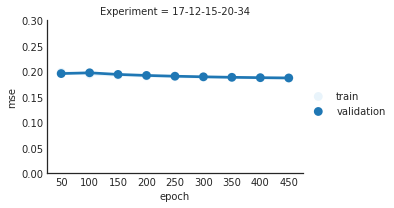

In [45]:
graphic_performances(dkt_train_performances)

## Performance metrics

In [60]:
DKT_FILENAMES = [
    '/home/mteruel/edm/results/dkt_lstm/original/predictions/17-12-15-17-23/predictions.p',
    '/home/mteruel/edm/results/dkt_lstm/original/predictions/17-12-15-20-12/predictions.p',
    '/home/mteruel/edm/results/dkt_lstm/original/predictions/17-12-15-20-34/predictions.p',
]

In [61]:
merge_sequences(get_metrics_all_iterations(DKT_FILENAMES))

111 sequences with only one class, ignoring.
121 sequences with only one class, ignoring.
116 sequences with only one class, ignoring.


,Filename,AUC-mean,AUC-std,RMSE-mean,RMSE-std,APS-mean,APS-std,Accuracy-mean,Accuracy-std,R2-mean,R2-std
0,-20-34/predictions.p,0.651948,0.183274,0.405755,0.122376,0.823056,0.152688,0.729531,0.165634,-0.052425,0.350200
1,-20-12/predictions.p,0.668168,0.171874,0.396469,0.117491,0.833237,0.150080,0.741326,0.163091,-0.033497,0.354876
2,-17-23/predictions.p,0.674740,0.178008,0.392388,0.119748,0.840051,0.146093,0.750326,0.162456,-0.022723,0.379569


In [62]:
get_not_averaged_metrics(DKT_FILENAMES)

,Filename,AUC,RMSE,APS,Accuracy,R2
0,/home/mteruel/edm/results/dkt_lstm/original/pr...,0.731531,0.436384,0.830381,0.714748,0.153422
1,/home/mteruel/edm/results/dkt_lstm/original/pr...,0.746460,0.432091,0.837256,0.719583,0.176230
2,/home/mteruel/edm/results/dkt_lstm/original/pr...,0.744786,0.431707,0.835155,0.721327,0.176968


# DKT + Embedding layer

## Learning curves

In [38]:
embedded_performance_filenames = [
    '/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/18-02-21-15-42/performances.p',
]
embedded_train_performances = read_performances(embedded_performance_filenames)

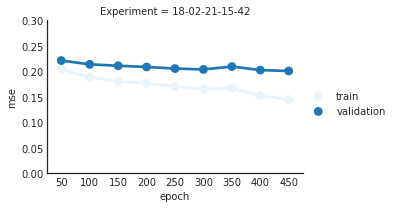

In [23]:
graphic_performances(embedded_train_performances)

## Generalized metrics

In [11]:
EMBEDDING_FILENAMES = [
    '/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/18-02-21-15-42/predictions.p',
    '/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/18-02-21-16-21/predictions.p',
]

In [12]:
merge_sequences(get_metrics_all_iterations(EMBEDDING_FILENAMES))

118 sequences ignored.
132 sequences ignored.


,Filename,AUC-mean,AUC-std,RMSE-mean,RMSE-std,APS-mean,APS-std,Accuracy-mean,Accuracy-std,R2-mean,R2-std
0,18-02-21-15-42,0.698236,0.166457,0.410663,0.135263,0.845416,0.147285,0.719927,0.153464,-0.130404,0.569160
1,18-02-21-16-21,0.700037,0.165499,0.424194,0.133709,0.833222,0.153761,0.707281,0.155780,-0.194607,0.821213


In [13]:
get_not_averaged_metrics(EMBEDDING_FILENAMES)

,Filename,AUC,RMSE,APS,Accuracy,R2
0,18-02-21-16-21,0.742320,0.444260,0.840101,0.710545,0.128583
1,18-02-21-15-42,0.749309,0.436463,0.851548,0.715337,0.146552


## Detailed metrics

In [15]:
test_prediction_file = '/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/18-02-21-15-42/predictions.p'

with open(test_prediction_file, 'rb') as prediction_file:
    true, predicted = pickle.load(prediction_file)

embedding_metrics = get_all_metrics(true, predicted)

132 sequences ignored.


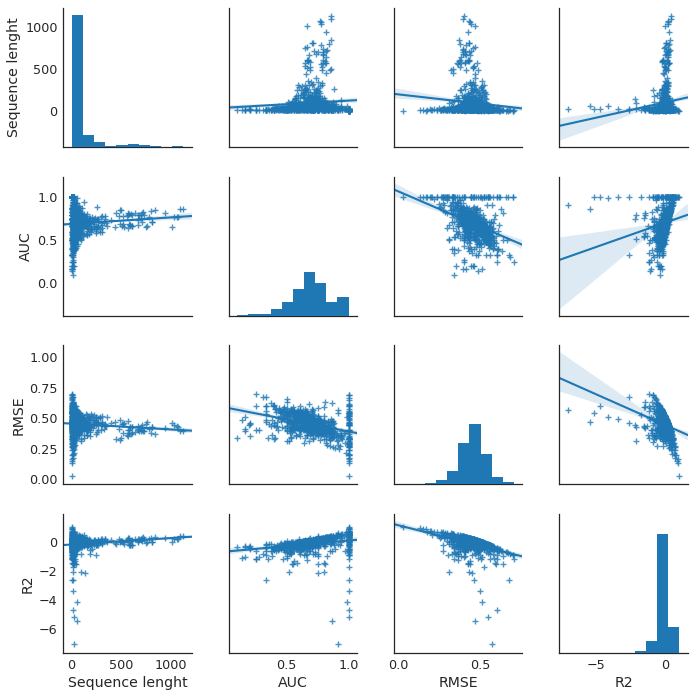

In [19]:
seaborn.pairplot(
    embedding_metrics[numpy.isfinite(embedding_metrics.AUC)][['Sequence lenght', 'AUC', 'RMSE', 'R2']],
    kind="reg", markers="+")

In [31]:
test_prediction_file = '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-21-18-45/predictions_run0.p'

with open(test_prediction_file, 'rb') as prediction_file:
    true, predicted = pickle.load(prediction_file)

embedding_metrics2 = get_all_metrics(true, predicted)

110 sequences ignored.


In [32]:
embedding_metrics['Experiment'] = 'E-LSTM'
embedding_metrics2['Experiment'] = 'CoE-LSTM'
merged = pandas.concat([embedding_metrics2[numpy.isfinite(embedding_metrics2.AUC)],
                        embedding_metrics[numpy.isfinite(embedding_metrics.AUC)]], ignore_index=True)


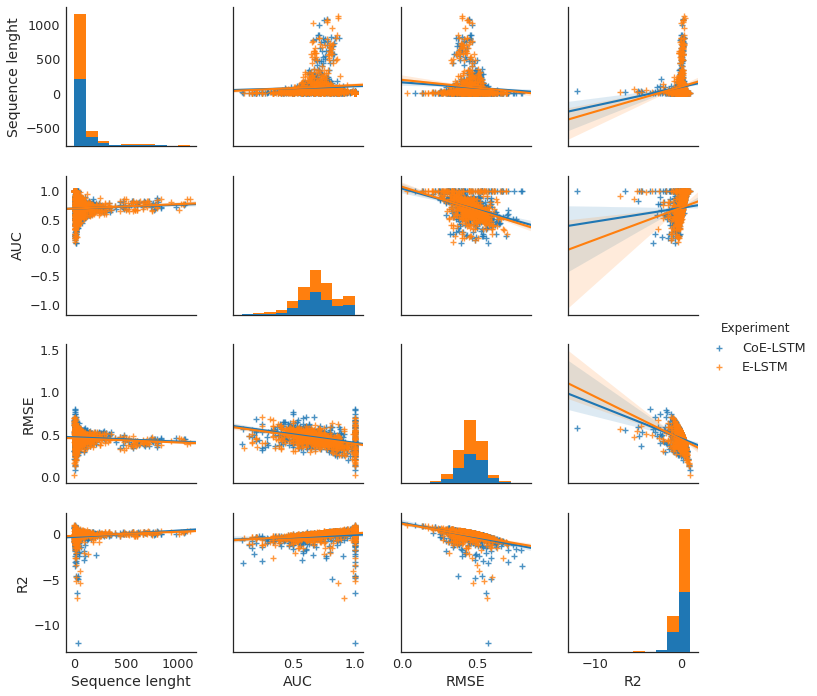

In [33]:
seaborn.pairplot(merged[['Sequence lenght', 'AUC', 'RMSE', 'R2', 'Experiment']],
    kind="reg", markers="+", hue='Experiment')

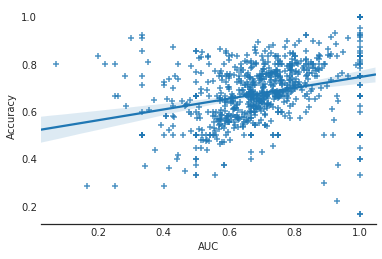

In [64]:
seaborn.regplot(x=embedding_metrics.AUC, y=embedding_metrics.Accuracy, marker="+")
seaborn.despine(left=True)

# Metrics according to position in sequence

In [34]:
def get_all_position_metrics(true, predicted):
    """Gets average metrics according to position of the prediction in the sequence"""
    results = []
    for true_sequence, predicted_sequence in zip(true, predicted):
        for index, (true_label, predicted_label) in enumerate(zip(true_sequence, predicted_sequence)):
            results.append([index, (numpy.abs(true_label - predicted_label))**0.5, int(true_label == round(predicted_label))])
    return pandas.DataFrame(results, columns=['Sequence position', 'SquaredError', 'Accuracy'])

In [35]:
position_metrics = get_all_position_metrics(true, predicted)

/home/mteruel/anaconda2/envs/edm_env2/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in double_scalars


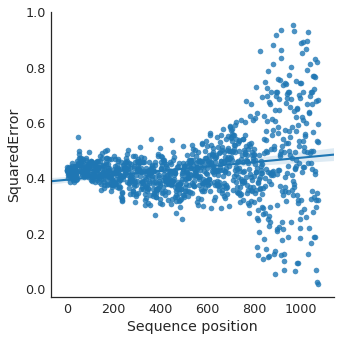

In [36]:
seaborn.lmplot(x='Sequence position', y='SquaredError', data=position_metrics.groupby('Sequence position').mean().reset_index())

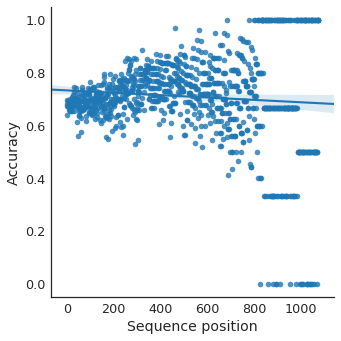

In [37]:
seaborn.lmplot(x='Sequence position', y='Accuracy', data=position_metrics.groupby('Sequence position').mean().reset_index())

In [76]:
def get_time_series_metrics(true, predicted):
    """Gets average metrics according to position of the prediction in the sequence"""
    results = []
    for sequence_index, (true_sequence, predicted_sequence) in enumerate(zip(true, predicted)):
        for index, (true_label, predicted_label) in enumerate(zip(true_sequence, predicted_sequence)):
            results.append([sequence_index, index, abs(true_label - predicted_label), int(true_label == round(predicted_label))])
    return pandas.DataFrame(results, columns=['Sequence', 'Time', 'MAE', 'Accuracy'])

In [77]:
time_series_metrics = get_time_series_metrics(true, predicted)

In [78]:
time_series_metrics[:20]

,Sequence,Time,MAE,Accuracy
0,0,0,0.082682,1
1,0,1,0.678471,0
2,0,2,0.816228,0
3,0,3,0.075623,1
4,0,4,0.303622,1
5,0,5,0.850327,0
6,0,6,0.411122,1
7,0,7,0.560598,0
8,0,8,0.253606,1
9,0,9,0.035163,1


/home/mteruel/anaconda2/envs/edm_env2/lib/python3.5/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


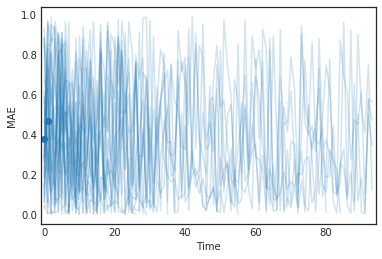

In [79]:
median_lenght = time_series_metrics.Time.median()
seaborn.tsplot(time="Time", value="MAE",
               unit="Sequence", data=time_series_metrics[time_series_metrics.Time < median_lenght][:1000],
               interpolate=False, err_style="unit_traces")

## Experiments with Co-embeddings